<a href="https://colab.research.google.com/github/030238220098-debug/-n/blob/main/examples/00_quick_start/als_movielens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running ALS on MovieLens (PySpark)

Matrix factorization by [ALS](https://spark.apache.org/docs/latest/api/python/_modules/pyspark/ml/recommendation.html#ALS) (Alternating Least Squares) is a well known collaborative filtering algorithm.

This notebook provides an example of how to utilize and evaluate ALS PySpark ML (DataFrame-based API) implementation, meant for large-scale distributed datasets. We use a smaller dataset in this example to run ALS efficiently on multiple cores of a [Data Science Virtual Machine](https://azure.microsoft.com/en-gb/services/virtual-machines/data-science-virtual-machines/).

# --- KHỐI 1. KHAI BÁO CÁC THƯ VIỆN CẦN THIẾT ---

In [60]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Import thư viện 'warnings' để tắt các cảnh báo không cần thiết

import sys
import pyspark
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.spark_splitters import spark_random_split
from recommenders.evaluation.spark_evaluation import SparkRatingEvaluation, SparkRankingEvaluation
from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.utils.notebook_utils import store_metadata

print(f"System version: {sys.version}")
print("Spark version: {}".format(pyspark.__version__))


System version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Spark version: 3.5.1


In [61]:
!pip install recommenders

# --- KHỐI 2: THIẾT ĐẶT CÁC THÔNG SỐ MẶC ĐỊNH ---




In [62]:
# Số lượng phim đề xuất cho mỗi user
TOP_K = 10

# Chọn kích thước bộ dữ liệu (100k, 1m, 10m, or 20m)
MOVIELENS_DATA_SIZE = '100k'

# Tên cột trong file dữ liệu
COL_USER = "UserID"
COL_ITEM = "MovieID"
COL_RATING = "Rating"
COL_TIMESTAMP = "Timestamp"

# --- KHỐI 3: KHỞI TẠO SPARK CONTEXT ---


In [63]:
# Khởi động hoặc lấy phiên Spark hiện có,
# và cấp phát 16GB RAM cho nó
spark = start_or_get_spark("ALS PySpark", memory="16g")
# (Cấu hình kỹ thuật của Spark SQL)
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")

# --- KHỐI 4: TẢI DỮ LIỆU MOVIELENS VÀ ĐỊNH NGHĨA SCHEMA ---


In [64]:
# ĐỊNH NGHĨA CẤU TRÚC DỮ LIỆU (SCHEMA) ==
# Khai báo rõ kiểu dữ liệu cho từng cột để Spark đọc file chính xác và tối ưu hóa bộ nhớ.
schema = StructType(
    (
        StructField(COL_USER, IntegerType()),
        StructField(COL_ITEM, IntegerType()),
        StructField(COL_RATING, FloatType()),
        StructField(COL_TIMESTAMP, LongType()),
    )
)

#TẢI DỮ LIỆU VÀO SPARK DATAFRAME
data = movielens.load_spark_df(spark, size=MOVIELENS_DATA_SIZE, schema=schema)
data.show()

100%|██████████| 4.81k/4.81k [00:00<00:00, 16.1kKB/s]


+------+-------+------+---------+
|UserID|MovieID|Rating|Timestamp|
+------+-------+------+---------+
|   196|    242|   3.0|881250949|
|   186|    302|   3.0|891717742|
|    22|    377|   1.0|878887116|
|   244|     51|   2.0|880606923|
|   166|    346|   1.0|886397596|
|   298|    474|   4.0|884182806|
|   115|    265|   2.0|881171488|
|   253|    465|   5.0|891628467|
|   305|    451|   3.0|886324817|
|     6|     86|   3.0|883603013|
|    62|    257|   2.0|879372434|
|   286|   1014|   5.0|879781125|
|   200|    222|   5.0|876042340|
|   210|     40|   3.0|891035994|
|   224|     29|   3.0|888104457|
|   303|    785|   3.0|879485318|
|   122|    387|   5.0|879270459|
|   194|    274|   2.0|879539794|
|   291|   1042|   4.0|874834944|
|   234|   1184|   2.0|892079237|
+------+-------+------+---------+
only showing top 20 rows



# --- KHỐI 5: PHÂN CHIA DỮ LIỆU (TRAIN/TEST) ---
# Mục đích: Chia dữ liệu thành 2 phần:
# 1. Tập Train (Huấn luyện): Dùng để "dạy" cho mô hình AI.
# 2. Tập Test (Kiểm tra): Dùng để "kiểm tra" xem mô hình AI dự đoán đúng không.

In [65]:
train, test = spark_random_split(data, ratio=0.75, seed=123)
print ("N train", train.cache().count())
print ("N test", test.cache().count())

N train 75018
N test 24982


# --- KHỐI 6: KHAI BÁO VÀ HUẤN LUYỆN MÔ HÌNH ALS ---
# Đây là bước "dạy học" cho bộ não AI

In [66]:
header = {
    "userCol": COL_USER,
    "itemCol": COL_ITEM,
    "ratingCol": COL_RATING,
}

# 6.1. Khai báo các tham số cho mô hình ALS
# Đây là các "thiết lập" cho bộ não AI trước khi nó học
als = ALS(
    rank=16,
    maxIter=15,
    implicitPrefs=False,
    regParam=0.1,
    # Chiến lược xử lý "Cold Start" (mặc định là "drop")
    coldStartStrategy='drop',
    # Các tham số kỹ thuật khác
    nonnegative=False,
    seed=42,
    **header
)

In [67]:
# 6.2. Đo thời gian và Huấn luyện mô hình
with Timer() as train_time:
    model = als.fit(train)

print("Took {} seconds for training.".format(train_time.interval))

Took 20.17844610300017 seconds for training.


# --- KHỐI 7: TẠO VÀ LỌC DANH SÁCH ĐỀ XUẤT ---
# Mục đích: Tạo đề xuất Top-K và loại bỏ những phim người dùng đã xem.

In [68]:
with Timer() as test_time:

    # TẠO MỌI CẶP (USER, ITEM) CÓ THỂ CÓ VÀ DỰ ĐOÁN ĐIỂM CHO TẤT CẢ CÁC CẶP
    users = train.select(COL_USER).distinct()
    items = train.select(COL_ITEM).distinct()
    user_item = users.crossJoin(items)
    dfs_pred = model.transform(user_item)

    # LỌC BỎ CÁC PHIM ĐÃ XEM
    dfs_pred_exclude_train = dfs_pred.alias("pred").join(
        train.alias("train"),
        (dfs_pred[COL_USER] == train[COL_USER]) & (dfs_pred[COL_ITEM] == train[COL_ITEM]),
        how='outer'
    )

    top_all = dfs_pred_exclude_train.filter(dfs_pred_exclude_train[f"train.{COL_RATING}"].isNull()) \
        .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

    # THỰC THI (ACTION)
    top_all.cache().count()

print("Took {} seconds for prediction.".format(test_time.interval))

Took 23.732527574000414 seconds for prediction.


In [69]:
top_all.show()

+------+-------+----------+
|UserID|MovieID|prediction|
+------+-------+----------+
|     1|    587| 3.6504607|
|     1|    869|  2.568271|
|     1|   1208| 2.4154637|
|     1|   1348| 1.0391247|
|     1|   1357| 1.0861548|
|     1|   1677| 2.8341696|
|     2|     80| 2.1940713|
|     2|    472| 2.9410315|
|     2|    582|  3.678034|
|     2|    838| 1.2914404|
|     2|    975| 2.9582283|
|     2|   1260| 2.1443088|
|     2|   1325| 1.1694545|
|     2|   1381|  3.629483|
|     2|   1530| 2.1645122|
|     3|     22| 2.9499638|
|     3|     57| 3.0160654|
|     3|     89| 3.8183079|
|     3|    367| 2.1727397|
|     3|   1091| 2.0200434|
+------+-------+----------+
only showing top 20 rows



# --- KHỐI 8: ĐÁNH GIÁ CHẤT LƯỢNG XẾP HẠNG (RANKING) ---
# Mục đích: Chấm điểm mô hình dựa trên chất lượng của danh sách Top-K
# (đo lường bằng nDCG@k, Precision@k...)


In [70]:
# KHỞI TẠO CÔNG CỤ ĐÁNH GIÁ
rank_eval = SparkRankingEvaluation(test, top_all, k = TOP_K, col_user=COL_USER, col_item=COL_ITEM,
                                    col_rating=COL_RATING, col_prediction="prediction",
                                    relevancy_method="top_k")

In [71]:
# IN KẾT QUẢ XẾP HẠNG
print("Model:\tALS",
      "Top K:\t%d" % rank_eval.k,
      "MAP:\t%f" % rank_eval.map_at_k(),
      "NDCG:\t%f" % rank_eval.ndcg_at_k(),
      "Precision@K:\t%f" % rank_eval.precision_at_k(),
      "Recall@K:\t%f" % rank_eval.recall_at_k(), sep='\n')

Model:	ALS
Top K:	10
MAP:	0.034866
NDCG:	0.083370
Precision@K:	0.077282
Recall@K:	0.031768


# --- KHỐI 9: ĐÁNH GIÁ ĐỘ CHÍNH XÁC DỰ ĐOÁN (RATING) ---
# Mục đích: Chấm điểm khả năng "dự đoán sao" (ví dụ: 4.5 sao) của mô hình.

In [72]:
# TẠO DỰ ĐOÁN TRÊN TẬP TEST
prediction = model.transform(test)
prediction.cache().show()


+------+-------+------+---------+----------+
|UserID|MovieID|Rating|Timestamp|prediction|
+------+-------+------+---------+----------+
|   148|     69|   5.0|877019101| 3.1654396|
|   148|     70|   5.0|877021271|  3.604662|
|   148|     78|   1.0|877399018| 1.5420145|
|   148|    127|   1.0|877399351|  4.341524|
|   148|    169|   5.0|877020297| 5.0473976|
|   148|    172|   5.0|877016513|  4.410916|
|   148|    175|   4.0|877016259| 4.3490157|
|   148|    181|   5.0|877399135|  4.281472|
|   148|    190|   2.0|877398586|   4.12321|
|   148|    194|   5.0|877015066| 3.8526096|
|   148|    214|   5.0|877019882|  2.412729|
|   148|    238|   4.0|877398586|  3.512637|
|   148|    474|   5.0|877019882| 4.5180845|
|   148|    496|   3.0|877015066| 3.8627822|
|   148|    507|   5.0|877398587| 4.0727453|
|   148|    529|   5.0|877398901| 4.5676064|
|   148|    588|   4.0|877399018| 4.0811615|
|   148|    713|   3.0|877021535| 3.9379768|
|   148|    969|   4.0|877398513| 3.9792495|
|   148|  

"Chấm điểm" cho các dự đoán rating

In [73]:
# KHỞI TẠO CÔNG CỤ ĐÁNH GIÁ
rating_eval = SparkRatingEvaluation(test, prediction, col_user=COL_USER, col_item=COL_ITEM,
                                    col_rating=COL_RATING, col_prediction="prediction")

# IN KẾT QUẢ LỖI DỰ ĐOÁN
print("Model:\tALS rating prediction",
      "RMSE:\t%f" % rating_eval.rmse(),
      "MAE:\t%f" % rating_eval.mae(),
      "Explained variance:\t%f" % rating_eval.exp_var(),
      "R squared:\t%f" % rating_eval.rsquared(), sep='\n')

Model:	ALS rating prediction
RMSE:	0.929158
MAE:	0.736171
Explained variance:	0.336844
R squared:	0.316967


In [76]:
# Ghi lại kết quả cho các bài kiểm tra
store_metadata("map", rank_eval.map_at_k())
store_metadata("ndcg", rank_eval.ndcg_at_k())
store_metadata("precision", rank_eval.precision_at_k())
store_metadata("recall", rank_eval.recall_at_k())
store_metadata("rmse", rating_eval.rmse())
store_metadata("mae", rating_eval.mae())
store_metadata("exp_var", rating_eval.exp_var())
store_metadata("rsquared", rating_eval.rsquared())
store_metadata("train_time", train_time.interval)
store_metadata("test_time", test_time.interval)

# --- KHỐI 10: KHÁM PHÁ DỮ LIỆU (VẼ BIỂU ĐỒ PHÂN BỐ) ---
# Mục đích: Chuyển đổi dữ liệu sang định dạng phù hợp để vẽ biểu đồ,
# nhằm "khám phá" và hiểu rõ hơn về đặc tính của dữ liệu.

Đang chuẩn bị dữ liệu để vẽ biểu đồ...
✅ Chuyển đổi 'data' sang Pandas thành công.
Ratings head:


,UserID,MovieID,Rating,Timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596



Basic stats:


,UserID,MovieID,Rating,Timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125754,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


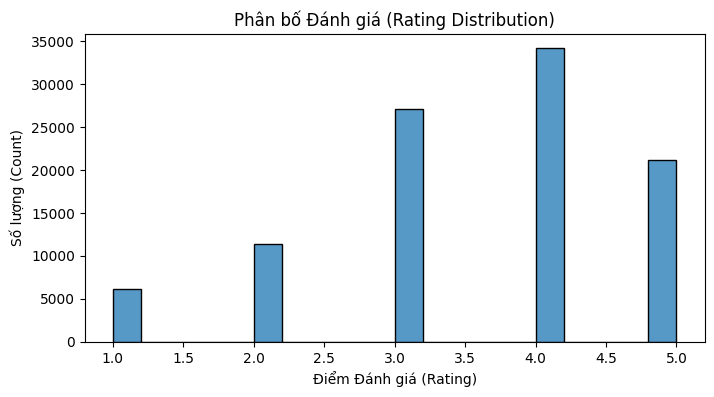

In [77]:
# 1. Nạp (import) các thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("Đang chuẩn bị dữ liệu để vẽ biểu đồ...")

# 2. Chuyển đổi Spark DataFrame ('data') sang Pandas DataFrame ('ratings_df')
try:
    ratings_df = data.toPandas()
    print("✅ Chuyển đổi 'data' sang Pandas thành công.")

    # 3. Hiển thị 5 dòng đầu tiên (Ratings head)
    print('Ratings head:')
    display(ratings_df.head())

    # 4. Hiển thị thống kê cơ bản (Basic stats)
    print('\nBasic stats:')
    display(ratings_df.describe(include='all'))

    # 5. Vẽ biểu đồ Phân bố Đánh giá (Rating Distribution)

    if 'Rating' in ratings_df.columns:
        plt.figure(figsize=(8,4))

        sns.histplot(ratings_df['Rating'], bins=20, kde=False)

        plt.title('Phân bố Đánh giá (Rating Distribution)')
        plt.xlabel('Điểm Đánh giá (Rating)')
        plt.ylabel('Số lượng (Count)')
        plt.show() # Hiển thị biểu đồ
    else:
        print("⚠️ Không tìm thấy cột 'Rating' để vẽ biểu đồ.")

except Exception as e:
    print(f"⚠️ Lỗi khi vẽ biểu đồ: {e}")
    print("Lỗi này có thể xảy ra nếu Spark Session đã bị 'spark.stop()'.")
    print("Hãy chạy 'Runtime -> Run all' lại từ đầu.")

# --- KHỐI 11: VẼ BIỂU ĐỒ "DỰ ĐOÁN vs. THỰC TẾ"  ---

Đang chuẩn bị dữ liệu cho biểu đồ 'Dự đoán vs Thực tế'...
✅ Chuyển đổi 'prediction' sang Pandas thành công.


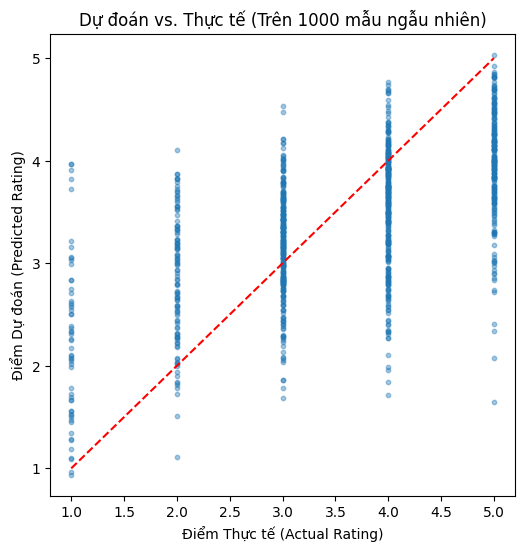

RMSE trên 1000 mẫu: 0.8963


In [78]:


print("Đang chuẩn bị dữ liệu cho biểu đồ 'Dự đoán vs Thực tế'...")

# 1. Nạp (import) thư viện 'mean_squared_error' để tính RMSE
from sklearn.metrics import mean_squared_error

# == TÍNH NĂNG 1: CHUYỂN ĐỔI SANG PANDAS ==
# Chuyển đổi Spark DataFrame 'prediction'  sang Pandas
p_df = prediction.toPandas()
print("✅ Chuyển đổi 'prediction' sang Pandas thành công.")

# == TÍNH NĂNG 2: LẤY MẪU NGẪU NHIÊN ==
# Lấy 1000 mẫu ngẫu nhiên từ 2 cột 'Rating' (thực tế) và 'prediction' (dự đoán)
samp = p_df[['Rating', 'prediction']].dropna().sample(n=min(1000, len(p_df)), random_state=42)

# == TÍNH NĂNG 3: VẼ BIỂU ĐỒ TÁN XẠ (SCATTER PLOT) ==
plt.figure(figsize=(6,6))

# Vẽ các điểm: trục X là 'Rating' (Thực tế), trục Y là 'prediction' (Dự đoán)
plt.scatter(samp['Rating'], samp['prediction'], alpha=0.4, s=10)

# == TÍNH NĂNG 4: VẼ ĐƯỜNG CHÉO LÝ TƯỞNG (MÀU ĐỎ) ==
# Đây là đường thẳng y=x (Dự đoán = Thực tế)
min_val = samp['Rating'].min()
max_val = samp['Rating'].max()
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.xlabel('Điểm Thực tế (Actual Rating)')
plt.ylabel('Điểm Dự đoán (Predicted Rating)')
plt.title('Dự đoán vs. Thực tế (Trên 1000 mẫu ngẫu nhiên)')
plt.show() # Hiển thị biểu đồ

# == TÍNH NĂNG 5: TÍNH LỖI RMSE (TRÊN MẪU) ==
# Tính và in ra chỉ số RMSE trên 1000 mẫu này để tham khảo
rmse_sample = np.sqrt(mean_squared_error(samp['Rating'], samp['prediction']))
print(f'RMSE trên 1000 mẫu: {rmse_sample:.4f}')



# --- Khối 12 : XỬ LÝ "COLD START" Định nghĩa "Sản phẩm Phổ biến nhất" ---
# Mục đích: Tạo một danh sách "Top 10 Phim Phổ biến nhất" (Top Popular).
# Danh sách này sẽ được dùng làm đề xuất "dự phòng" (fallback) cho những người dùng mới (new users) mà hệ thống chưa có dữ liệu.

In [79]:
import pyspark.sql.functions as F


# Đặt ra một ngưỡng, ví dụ: ít nhất phải có 50 lượt đánh giá mới đáng tin cậy
COL_PREDICTION = "prediction"
MIN_RATINGS_THRESHOLD = 50
TOP_K_POPULAR = 10

print(f"Đang tính toán Top {TOP_K_POPULAR} sản phẩm phổ biến nhất (với >{MIN_RATINGS_THRESHOLD} lượt đánh giá)...")

# 1. Tính toán số lượt rating (rating_count) và rating trung bình (avg_rating) cho mỗi phim
movie_popularity = (
    data.groupBy(COL_ITEM)  # 'data' là DataFrame gốc chứa tất cả ratings
    .agg(
        F.count(COL_RATING).alias("rating_count"),
        F.avg(COL_RATING).alias("avg_rating")
    )
)

# 2. Lọc ra những phim có đủ số lượt đánh giá (để tránh bị nhiễu)
top_popular_df = (
    movie_popularity
    .filter(F.col("rating_count") >= MIN_RATINGS_THRESHOLD)
    .orderBy(F.desc("avg_rating")) # Sắp xếp theo điểm trung bình cao nhất
    .limit(TOP_K_POPULAR) # Lấy top 10
)

# 3. Định dạng lại cho giống với output của ALS (quan trọng)
# Output của ALS có dạng (movieID, prediction)
# Ở đây, chúng ta dùng avg_rating làm "prediction"
top_popular_list = (
    top_popular_df
    .select(COL_ITEM, F.col("avg_rating").alias(COL_PREDICTION))
    .collect() # Lấy kết quả về
)

# Biến này sẽ là danh sách dự phòng của chúng ta
# Nó sẽ có dạng: [Row(movieID=318, prediction=4.5), Row(movieID=858, prediction=4.4), ...]
print("Hoàn tất. Danh sách dự phòng đã sẵn sàng.")
top_popular_df.show()

Đang tính toán Top 10 sản phẩm phổ biến nhất (với >50 lượt đánh giá)...
Hoàn tất. Danh sách dự phòng đã sẵn sàng.
+-------+------------+------------------+
|MovieID|rating_count|        avg_rating|
+-------+------------+------------------+
|    408|         112| 4.491071428571429|
|    318|         298| 4.466442953020135|
|    169|         118| 4.466101694915254|
|    483|         243|  4.45679012345679|
|    114|          67| 4.447761194029851|
|     64|         283| 4.445229681978798|
|    603|         209|4.3875598086124405|
|     12|         267| 4.385767790262173|
|     50|         583|4.3584905660377355|
|    178|         125|             4.344|
+-------+------------+------------------+



# --- KHỐI 13: TẠO DANH SÁCH "NGƯỜI DÙNG ĐÃ BIẾT" (KNOWN USERS) ---
# Mục đích: Tạo ra một 'Set' (tập hợp) chứa ID của tất cả người dùng đã có trong tập huấn luyện (tập 'train').
# Việc này giúp chúng ta kiểm tra một user là "Cũ" hay "Mới" (Cold Start) một cách siêu nhanh.

In [80]:
# Lấy danh sách tất cả userID duy nhất từ tập train
known_users_df = train.select(COL_USER).distinct()

# Chuyển thành một Set (tập hợp) để tra cứu siêu nhanh
known_users_set = set(row[COL_USER] for row in known_users_df.collect())

print(f"Đã tạo danh sách {len(known_users_set)} người dùng đã biết.")

Đã tạo danh sách 943 người dùng đã biết.


# --- KHỐI 14: XÂY DỰNG HÀM ĐỀ XUẤT CHÍNH (CÓ XỬ LÝ COLD START) ---
# Mục đích: Đây là hàm logic trung tâm. Dựa vào 'user_id' nhận vào, \nó sẽ quyết định dùng "Mô hình AI" (cho user cũ) hay dùng "Top Phổ biến" (cho user mới).

In [81]:
def get_recommendations_for_user(user_id, model, known_users, popular_list, top_k):
    """
    Hàm lấy đề xuất cho 1 user, có xử lý Cold Start.

    :param user_id: ID của người dùng cần đề xuất
    :param model: Mô hình ALS đã huấn luyện (bestModel của em)
    :param known_users: Set (tập hợp) các user mà mô hình đã "biết"
    :param popular_list: Danh sách [Row(movieID, prediction)] các sản phẩm phổ biến
    :param top_k: Số lượng sản phẩm cần đề xuất
    :return: Một danh sách đề xuất (list of Rows)
    """
# KIỂM TRA USER CŨ HAY MỚI
    if user_id in known_users:

        # ---- TRƯỜNG HỢP 1: NGƯỜI DÙNG ĐÃ BIẾT ----
        # 1. Tạo DataFrame tạm thời chỉ chứa 1 user này
        user_df = spark.createDataFrame([(user_id,)], [COL_USER])

        # 2. Yêu cầu mô hình AI ('model') đề xuất cho user này
        user_recs_df = model.recommendForUserSubset(user_df, top_k)

        # 3. Trích xuất danh sách đề xuất từ kết quả DataFrame
        # (Kết quả trả về là một list chứa các Row(MovieID, rating))

        recs_list = user_recs_df.select("recommendations").collect()[0][0]

        return recs_list

    else:
        # ---- TRƯỜNG HỢP 2: NGƯỜI DÙNG MỚI (COLD START) ----
        # Nếu user_id KHÔNG có trong 'known_users'
        print(f"Phát hiện Cold Start cho User {user_id}. Trả về Top {top_k} Popular.")

        # Trả về danh sách Top Popular đã tính sẵn
        # Cắt danh sách này để lấy đúng top_k
        return popular_list[:top_k]

# --- KHỐI 15: TẠO MÔ HÌNH TỐI ƯU VÀ CHẠY THỬ NGHIỆM ---

In [82]:
# --- TẠO MÔ HÌNH TỐI ƯU ---

print("Đang huấn luyện mô hình TỐI ƯU (rank=16, regParam=0.1)...")

# 1. Khai báo ALS với tham số tốt nhất từ Lần chạy 15
als_best = ALS(
    rank = 16,      # <--- Tham số tốt nhất
    maxIter = 15,   # (Giữ nguyên)
    regParam = 0.1, # <--- Tham số tốt nhất
    userCol=COL_USER,
    itemCol=COL_ITEM,
    ratingCol=COL_RATING,
    coldStartStrategy="drop",
    nonnegative=True
)

# 2. Huấn luyện (fit) mô hình trên toàn bộ tập train
# DÒNG NÀY SẼ TẠO RA BIẾN 'bestModel'
bestModel = als_best.fit(train)

print("Đã huấn luyện xong 'bestModel'. Sẵn sàng cho Cold Start.")

Đang huấn luyện mô hình TỐI ƯU (rank=16, regParam=0.1)...
Đã huấn luyện xong 'bestModel'. Sẵn sàng cho Cold Start.


In [83]:
# ---- Thử nghiệm 1: User cũ (ID = 1) ----
USER_ID_OLD = 1
print(f"\n--- Đang lấy đề xuất cho User CŨ (ID: {USER_ID_OLD}) ---")
recs_old = get_recommendations_for_user(USER_ID_OLD, bestModel, known_users_set, top_popular_list, TOP_K)
print(recs_old)


# ---- Thử nghiệm 2: User mới (ID = 999999, một ID không có trong data) ----
USER_ID_NEW = 999999
print(f"\n--- Đang lấy đề xuất cho User MỚI (ID: {USER_ID_NEW}) ---")
recs_new = get_recommendations_for_user(USER_ID_NEW, bestModel, known_users_set, top_popular_list, TOP_K)
print(recs_new)


--- Đang lấy đề xuất cho User CŨ (ID: 1) ---
[Row(MovieID=114, rating=5.070295333862305), Row(MovieID=1104, rating=4.957250595092773), Row(MovieID=408, rating=4.9335527420043945), Row(MovieID=511, rating=4.795600891113281), Row(MovieID=169, rating=4.791985511779785), Row(MovieID=12, rating=4.7546467781066895), Row(MovieID=127, rating=4.752811431884766), Row(MovieID=187, rating=4.717949867248535), Row(MovieID=1142, rating=4.701803684234619), Row(MovieID=50, rating=4.688486099243164)]

--- Đang lấy đề xuất cho User MỚI (ID: 999999) ---
Phát hiện Cold Start cho User 999999. Trả về Top 10 Popular.
[Row(MovieID=408, prediction=4.491071428571429), Row(MovieID=318, prediction=4.466442953020135), Row(MovieID=169, prediction=4.466101694915254), Row(MovieID=483, prediction=4.45679012345679), Row(MovieID=114, prediction=4.447761194029851), Row(MovieID=64, prediction=4.445229681978798), Row(MovieID=603, prediction=4.3875598086124405), Row(MovieID=12, prediction=4.385767790262173), Row(MovieID=50,

Dùng Streamlit để Giả Lập Tương Tác (Mock-up)

Code tạo file recommendations.json

In [84]:
import json


# --- HÀM TRÍCH XUẤT ID PHIM ---
# Vì hàm của chúng ta trả về 2 kiểu dữ liệu khác nhau (cho user cũ/mới) nên chúng ta cần một hàm để chuẩn hóa chúng.
def extract_movie_ids(result):
    if isinstance(result, list):
        # TRƯỜNG HỢP 1: User Mới (Cold Start)
        # Kết quả là: [Row(movieID=318, prediction=4.5), ...]
        return [row.MovieID for row in result] # Changed from movieID to MovieID
    else:
        # TRƯỜNG HỢP 2: User Cũ (Personalized)
        # Kết quả là: Row(recommendations=Row(MovieId=[1104, 408,...], Rating=[5.05,...]))
        # Need to access the nested list within 'recommendations' and then 'MovieID'
        return result.recommendations.MovieID # Corrected access to nested MovieID list


# --- TÍNH TOÁN KẾT QUẢ TRƯỚC ---
print("Lấy kết quả cho User 1 (cũ)...")
recs_1_raw = get_recommendations_for_user(1, bestModel, known_users_set, top_popular_list, TOP_K)

print("Lấy kết quả cho User 2 (cũ)...")
recs_2_raw = get_recommendations_for_user(2, bestModel, known_users_set, top_popular_list, TOP_K)

print("Lấy kết quả cho User 999999 (mới - Cold Start)...")
recs_999999_raw = get_recommendations_for_user(999999, bestModel, known_users_set, top_popular_list, TOP_K)

# --- TẠO DỮ LIỆU PYTHON (DICTIONARY) ---
# Chúng ta sẽ chỉ lấy 5 phim đầu tiên cho demo
recs_data = {
  "1": {
    "type": "Personalized",
    "movies": extract_movie_ids(recs_1_raw)[:5] # Lấy 5 phim đầu
  },
  "2": {
    "type": "Personalized",
    "movies": extract_movie_ids(recs_2_raw)[:5] # Lấy 5 phim đầu
  },
  "999999": {
    "type": "Cold Start (Top Popular)",
    "movies": extract_movie_ids(recs_999999_raw)[:5] # Lấy 5 phim đầu
  }
}

# --- GHI RA FILE JSON ---
file_path = "recommendations.json"
with open(file_path, "w", encoding="utf-8") as f:
    json.dump(recs_data, f, indent=2) # indent=2 để file trông đẹp

print(f"ĐÃ TẠO FILE '{file_path}' THÀNH CÔNG!")
print("EM HÃY NHÌN SANG BÊN TRÁI, TÌM FILE VÀ TẢI VỀ MÁY TÍNH.")

Lấy kết quả cho User 1 (cũ)...
Lấy kết quả cho User 2 (cũ)...
Lấy kết quả cho User 999999 (mới - Cold Start)...
Phát hiện Cold Start cho User 999999. Trả về Top 10 Popular.
ĐÃ TẠO FILE 'recommendations.json' THÀNH CÔNG!
EM HÃY NHÌN SANG BÊN TRÁI, TÌM FILE VÀ TẢI VỀ MÁY TÍNH.


In [ ]:
# cleanup spark instance
# spark.stop() # Moved to the end of the notebook